In [23]:
import csv
import time
from pylsl import StreamInlet, resolve_byprop
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import math
import sys
import threading

# CSVファイルにデータを保存する関数
def save_data_to_csv(start_time, timestamp, data, filename):
    fieldnames = ['timestamp', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    with open(filename, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # ヘッダーがない場合は、ヘッダーを書き込む
        csvfile.seek(0, 2)
        if csvfile.tell() == 0:
            writer.writeheader()

        # Start time subtraction for relative timestamps
        relative_timestamp = lsl_to_local_datetime(timestamp) - start_time
        row = {'timestamp': relative_timestamp.total_seconds()}
        row.update({fieldnames[i + 1]: data[i+3] for i in range(len(data)-5)})
        writer.writerow(row)
        
# マーカー付きデータをｃｓｖ保存
def save_data_to_csv_with_marker(start_time, timestamp, sample, marker, filename):
    # 開始と終了の3つの要素を削除し、タイムスタンプを0から始まるように修正
    sample = sample[3:-2]
    timestamp -= start_time
    
    # DataFrameを作成し、データを追記していく
    # sampleはリスト形式でデータが渡される
    # マーカーもこのDataFrameに格納
    # タイムスタンプを先頭に追加
    df = pd.DataFrame([[timestamp] + sample + [marker]])  

    with open(filename, 'a') as f:
        df.to_csv(f, header=f.tell() == 0, index=False, lineterminator='\n')  # headerはファイルの先頭だけに出力


#CSVファイルからデータを読み込む関数
def load_data_from_csv(filename):
    data = []
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data.append(row)

    return data

# データをプロットする関数
def plot_data(data, channels):
    timestamps = [float(row['timestamp']) for row in data]

    plt.figure(figsize=(15, 8))

    for channel in channels:
        values = [float(row[channel]) for row in data]
        plt.plot(timestamps, values, label=channel)

    plt.xlabel('Timestamp (s)')
    plt.ylabel('Sensor Value')
    plt.title('Brainwave Data')
    plt.legend()
    plt.show()
    
def plot_data_for_parallel(data, channels, title, subplot_position):
    plt.subplot(1, 2, subplot_position)
    time = np.arange(len(data)) / 256.0  # Create a time array (assuming data was collected at 256 Hz)

    for channel in channels:
        plt.plot(time, data[channel], label=channel)

    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    
    
# マーカー付きデータをプロットする関数
def plot_data_with_marker(data, channels):
    timestamps = [float(row['Timestamp']) for row in data]
    markers = [row['Marker'] for row in data]

    plt.figure(figsize=(15, 8))

    for channel in channels:
        values = [float(row[channel]) for row in data]
        plt.plot(timestamps, values, label=channel)

    # Add a vertical line at the marker position(s)
    marker_set = False
    for i, mark in enumerate(markers):
        if mark == '1' and not marker_set:  # Add marker only at first occurrence
            plt.axvline(x=timestamps[i], color='r', linestyle='--', label='Marker')
            marker_set = True
            
    # Remove duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel('Timestamp (s)')
    plt.ylabel('Sensor Value')
    plt.title('Brainwave Data')
    plt.show()

    
def lsl_to_local_datetime(lsl_timestamp):
    return datetime.fromtimestamp(lsl_timestamp)


# データの収集が開始されてから３秒間、カウントダウンを行う
# カウントダウンが終了した時点でマーカーを追加
# 256Hzで収集（デフォルト）
def collect_EEG(filename, duration):
    # EPOCXのストリームを探す
    streams = resolve_byprop('type', 'EEG', timeout=5)

    if not streams:
        raise RuntimeError("No EEG stream found. Make sure the EmotivPro LSL Connector is running.")

    # ストリームを開く
    inlet = StreamInlet(streams[0])

    print("Connected to Emotiv EPOCX stream.")

    # ファイルを上書きモードで開く
    with open(filename, 'w') as f:
        # チャンネル名のラベルを設定
        header = ['Timestamp'] + ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'] + ['Marker']
        f.write(','.join(header) + '\n')

    # データを取得し、CSVファイルに記録する
    start_time = None
    marker_set = False
    countdown_val = 3.0  # カウントダウン開始値
    countdown_lock = threading.Lock()  # スレッド間で値を共有するためのロック

    #収集開始
    def collect_data():
        nonlocal start_time, marker_set
        while True:
            sample, timestamp = inlet.pull_sample()
            if start_time is None:
                start_time = timestamp
            elapsed_time = timestamp - start_time

            if not marker_set and elapsed_time >= 3:
                print("Marker set.")
                sys.stdout.flush()  # 出力バッファを強制的にフラッシュ
                marker_set = True

            marker = 1 if elapsed_time >= 3 else 0  # 3秒後にマーカーを設定
            save_data_to_csv_with_marker(start_time, timestamp, sample, marker, filename)  # マーカーの情報を含むように関数を修正

            if elapsed_time >= duration:
                break

    # カウントダウン表示
    def countdown():
        nonlocal countdown_val
        while countdown_val >= 0:
            with countdown_lock:  # ロックを取得してから値を操作
                print(f"Countdown: {countdown_val:.1f}")
                countdown_val -= 0.5  # カウントダウン値を減らす
            sys.stdout.flush()  # 出力バッファを強制的にフラッシュ
            time.sleep(0.5)  # 0.5秒間隔で表示するために追加

    # スレッドの生成と開始
    collection_thread = threading.Thread(target=collect_data)
    countdown_thread = threading.Thread(target=countdown)
    collection_thread.start()
    countdown_thread.start()

    # スレッドが終了するのを待つ
    collection_thread.join()
    countdown_thread.join()

    print("done.")
    return

Connected to Emotiv EPOCX stream.
Countdown: 3.0
Countdown: 2.5
Countdown: 2.0
Countdown: 1.5
Countdown: 1.0
Countdown: 0.5
Countdown: 0.0
Marker set.
done.


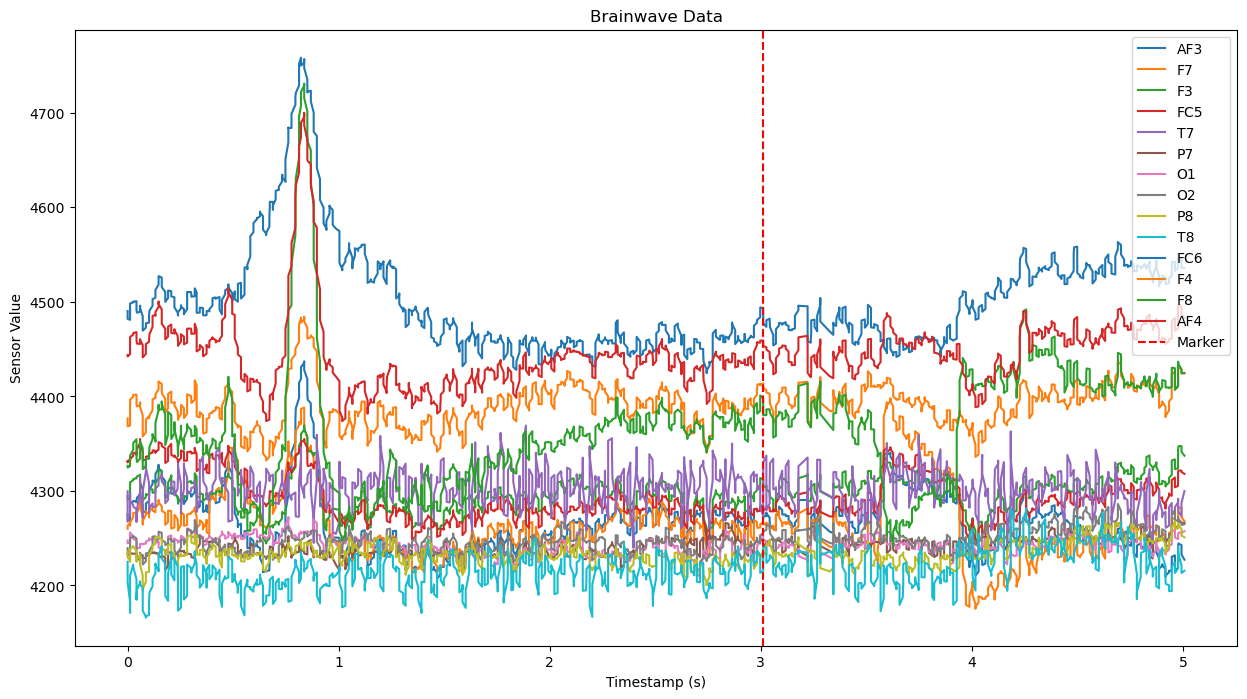

In [26]:
# CSVファイル名を指定
filename = 'DetectPain_3.csv'
#収集するデータの期間（秒）
duration = 5
# 選択したチャンネル名
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

#EEGを収集し、csvファイルに保存
collect_EEG(filename, duration)

#取得したEEGをplot
data = load_data_from_csv(filename)
plot_data_with_marker(data, channels)

In [27]:
"""
filename1 = ''
data1 = load_data_from_csv(filename1)

filename2 = ''
data2 = load_data_from_csv(filename2)
    
plt.figure(figsize=(20, 10))

# データを平行に２つプロット
plot_data_for_parallel(data1, channels, filename1, 1)
plot_data_for_parallel(data2, channels, filename2, 2)

plt.show()
"""

"\nfilename1 = ''\ndata1 = load_data_from_csv(filename1)\n\nfilename2 = ''\ndata2 = load_data_from_csv(filename2)\n    \nplt.figure(figsize=(20, 10))\n\n# データを平行に２つプロット\nplot_data_for_parallel(data1, channels, filename1, 1)\nplot_data_for_parallel(data2, channels, filename2, 2)\n\nplt.show()\n"